![](https://media.sproutsocial.com/uploads/2019/03/sentiment-analysis.svg "credit: https://sproutsocial.com/insights/social-media-sentiment-analysis/")


# Libraires & Configuration

### Check GPU

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Libraries 

### Install `Tensorflow Text`

We need `tensorflow_text` for **Universal Sentence Encoder (USE)**

---
latest version of `tensorflow_text==2.8.1` may cause crashes with kaggle GPU. I tried with different version of `tensorflow_text` and ended up with **v2.6**

In [2]:
%%capture
!pip install tensorflow_text==2.6.0

In [3]:
# import os
#
# # session crash issue
# # https://stackoverflow.com/a/54927279/11105356
#
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
from tqdm import tqdm
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

from numpy import newaxis
from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import xgboost as xgb
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Activation, GRU, BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

plt.rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

nltk.download('stopwords')
stop_words = stopwords.words('english')

2023-02-10 16:16:24.392014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 16:16:24.477805: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-10 16:16:24.480571: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-10 16:16:24.480582: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

### GPU Test

In [5]:
tf.test.gpu_device_name()

2023-02-10 16:16:25.704844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 16:16:25.705924: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-10 16:16:25.705939: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-10 16:16:25.705955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (happygargarin-Laptop-12th-Gen-Intel-Core): /proc/driver/nvidia/version does not exist


''

#### Important Package Version

In [6]:
tf.__version__, hub.__version__, tensorflow_text.__version__

('2.11.0', '0.12.0', '2.11.0')

In [7]:
!pip freeze | grep hub
!pip freeze | grep tensorflow_text
!pip freeze | grep keras
!pip freeze | grep scikit-learn

en-core-web-md @ https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.4.1/en_core_web_md-3.4.1-py3-none-any.whl
huggingface-hub==0.11.1
tensorflow-hub==0.12.0
keras==2.11.0
scikit-learn==1.2.0


## Load HUB Model
---
**USE(Universal Sentence Encoder)**

In [8]:
# module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'
module_url = './use/'
use = hub.load(module_url)

### Sample Text Embedding With USE

In [9]:
txt_1 = ["the bedroom is cozy"]
txt_2 = ["comfortable bedroom"]

In [10]:
emb_1 = use(txt_1)
emb_2 = use(txt_2)

#### Embedding Dimension

In [11]:
print(emb_1.shape)

(1, 512)


#### Correlation

The USE is trained on a number of tasks but one of the main tasks is to identify the similarity between pairs of sentences. 
The authors note that the task was to identify **"semantic textual similarity (STS) between sentence pairs scored by Pearson correlation with human judgments"**.

In [12]:
print(np.inner(emb_1, emb_2).flatten()[0])

0.5340151


# EDA

In [13]:
# df_hotel_reviews = pd.read_csv("../input/515k-hotel-reviews-data-in-europe/Hotel_Reviews.csv")
# df_hotel_reviews.head()

In [14]:
# print(f"{df_hotel_reviews.shape[0]} rows, {df_hotel_reviews.shape[1]} columns")

#### Columns

In [15]:
# df_hotel_reviews.columns.tolist()

## Review Score

## Review Sentiment Distribution

## Reviewer Nationality

### Top 20

## Positive Vs Negative Word Count Among Hotel Reviews

# Data Preprocessing

## Cleaning Review Text

> There are some values like `No Positive` in positive review and `No Negative` in negative review which can be counted ass opposite sentiment, hence replacing those phrases

## Merge Feature (Both Review Text)
> I will merge texts from both positive and negative review columns to merge into a single text feature

## Set Sentiment Type
> Setting the sentiment threshold to **7**, everything is negative below **7**

## Final Preprocessed Dataset

## Review Type Distribution

#### Texts labeled as **`Good`**

#### Texts labeled as **`Bad`**

#### Texts labeled as **`Good`**

## Word Cloud

### `Good` Reviews

### `Bad` Reviews

## Resample Dataset

Under sample the positive review to achieve a balanced distribution between reviews

#### After Resampled

## Data Preparation

### Encoding Labels

In [16]:
import string
import pandas as pd

pd.options.mode.chained_assignment = None
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from numpy.compat import unicode
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import svm
from sklearn.linear_model import SGDClassifier
import spacy
from sklearn.metrics import f1_score,precision_score,recall_score,hamming_loss,jaccard_score

# Pour les deux dernieres experiences avec reseaux de Neurones
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers
from prettytable import PrettyTable
def remove_stops(text, stops):
    # text = re.sub(r"AC\/\d{1,4}\/\d{1,4}", "", text)
    wordnet_lemmatizer = WordNetLemmatizer()
    words = text.split()
    final = []
    for word in words:
        if word not in stops:
            word = wordnet_lemmatizer.lemmatize(word, pos="v")
            final.append(word)
    final = " ".join(final)
    final = final.translate(str.maketrans("", "", string.punctuation))
    # final = "".join([i for i in final if not i.isdigit()])
    final = "".join([i for i in final])
    while "  " in final:
        final = final.replace("  ", " ")
    return final


def clean_docs(docs):
    stops = stopwords.words("english")
    final = []
    for doc in docs:
        clean_doc = remove_stops(doc, stops)
        final.append(clean_doc)
    return final


def most_tags(dataframe, nbr_tags: int = 150):
    vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: str(x).split(" "))
    tag_vect = vectorizer.fit_transform(dataframe["Tags"])
    tags = vectorizer.get_feature_names_out()
    freqs = tag_vect.sum(axis=0).A1
    result = list(zip(tags, freqs))
    tag_counts = pd.DataFrame(result, columns=['tag', 'tag_counts']).sort_values(['tag_counts'], ascending=False)

    tags_kept = list(tag_counts['tag'].head(nbr_tags))

    print(f"Top ten tags  : {tags_kept[:10]}")
    print(f"Number of tags kept : {len(tags_kept)}")

    from tqdm import tqdm

    for le in tqdm(range(dataframe.shape[0])):
        a = []
        b = dataframe['Tags'][le].split(" ")

        for i in range(len(b)):
            for j in tags_kept:
                temp = b[i].strip()  #Stripping the white-spaces present(if any) around the tag
                if temp == j:
                    a.append(j)
        if a:
            dataframe['Tags'][le] = " ".join(a)
        else:
            dataframe['Tags'][le] = np.nan
    dataframe = dataframe.dropna()
    print(dataframe.shape)
    return dataframe


df = pd.read_csv('../QueryResults.csv')
df["Tags"] = df["Tags"].str.lstrip('<').str.replace('<', ' ').str.replace('>', '')
df.head()

df['CleanTitle'] = clean_docs(df['Title'])
data = most_tags(df)

data.drop(
    data[df['Tags'].isin(data['Tags'].value_counts().loc[lambda x: x == 1].reset_index()['index'].tolist())].index,
    inplace=True)
data.shape

/home/happy-gargarin/Desktop/ocr/projet_5/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Top ten tags  : ['c#', 'java', 'python', 'javascript', 'c++', '.net', 'android', 'php', 'html', 'jquery']
Number of tags kept : 150


100%|██████████| 50000/50000 [00:07<00:00, 6846.01it/s]

(39324, 9)



/tmp/ipykernel_41433/4090540394.py:104: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[df['Tags'].isin(data['Tags'].value_counts().loc[lambda x: x == 1].reset_index()['index'].tolist())].index,


(35462, 9)

### Train/test Split

In [17]:
mlb = MultiLabelBinarizer()
X = data["CleanTitle"]
# X = use_model(data["CleanTitle"])
y = mlb.fit_transform(data["Tags"].apply(lambda x: x.split(" ")))

In [18]:
mlb.classes_

array(['.net', 'ajax', 'algorithm', 'amazon-web-services', 'android',
       'android-studio', 'angular', 'angularjs', 'apache', 'arrays',
       'asp.net', 'asp.net-mvc', 'authentication', 'bash', 'c', 'c#',
       'c++', 'c++11', 'caching', 'class', 'cocoa', 'cocoa-touch',
       'coding-style', 'collections', 'command-line', 'css', 'database',
       'database-design', 'date', 'datetime', 'debugging', 'delphi',
       'design-patterns', 'dictionary', 'django', 'docker', 'dom',
       'eclipse', 'emacs', 'entity-framework', 'enums', 'events', 'excel',
       'exception', 'file', 'firebase', 'firefox', 'flutter', 'forms',
       'function', 'functional-programming', 'gcc', 'generics', 'git',
       'go', 'google-chrome', 'haskell', 'hibernate', 'html', 'http',
       'image', 'inheritance', 'internet-explorer', 'ios', 'ios7',
       'iphone', 'java', 'javascript', 'jquery', 'json',
       'language-agnostic', 'laravel', 'linq', 'linq-to-sql', 'linux',
       'list', 'logging', 'macos'

In [19]:
train_reviews, test_reviews, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25, 
    random_state=RANDOM_SEED
  )

# Modeling

## Feature Engineering

### TF-IDF

In [20]:
%%time
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=True,smooth_idf=True,sublinear_tf=True,
            stop_words = 'english')

tfv.fit(list(train_reviews) + list(test_reviews))

X_train_tfv =  tfv.transform(train_reviews) 
X_test_tfv = tfv.transform(test_reviews)

CPU times: user 825 ms, sys: 3.22 ms, total: 828 ms
Wall time: 827 ms


#### LSA Plot

In [21]:
# FYI LSA -> Latent semantic analysis 

# def plot_LSA(test_data, test_labels):
#     lsa = TruncatedSVD(n_components=2)
#     lsa.fit(test_data)
#     lsa_scores = lsa.transform(test_data)
#
#     colors = ['orange','blue']
#     plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
#     orange_patch = mpatches.Patch(color='orange', label='Positive')
#     blue_patch = mpatches.Patch(color='blue', label='Negative')
#     plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})
#
# fig = plt.figure(figsize=(12, 12))
# plot_LSA(X_train_tfv, y_train)
# plt.show()

### Count Features

In [22]:
%%time
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(train_reviews) + list(test_reviews))

X_train_ctv=  ctv.transform(train_reviews) 
X_test_ctv = ctv.transform(test_reviews)

CPU times: user 1.08 s, sys: 19.8 ms, total: 1.1 s
Wall time: 1.1 s


#### LSA Plot

In [23]:
# fig = plt.figure(figsize=(12, 12))
# plot_LSA(X_train_ctv, y_train)
# plt.show()

# Logistic Regression

**Utility Function**

In [24]:
def model_predict(clf, X_train,y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    predictions = clf.predict_proba(X_test)
    predictions = np.where(predictions > .70, 1, 0)

    jaccard = round(jaccard_score(y_test, predictions, average='micro'), 3)
    # f1_score_ = round(2*((precision * recall)/(precision + recall)), 3)
    f1 = f1_score(y_test, predictions, average='micro')
    print (f"logloss: {metrics.log_loss(y_test, predictions):0.3f}", jaccard, f1, sep="\n")

In [25]:
%%time
# issue: https://stackoverflow.com/a/66560912/11105356
clf = OneVsRestClassifier(LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000))

# count vector feature
model_predict(clf, X_train_ctv,y_train, X_test_ctv, y_test)

logloss: 13.873
0.281
0.43837829106767895
CPU times: user 16min 35s, sys: 36min 16s, total: 52min 52s
Wall time: 4min 40s


In [26]:
%%time

# Tf-IDF feature 
model_predict(clf, X_train_tfv,y_train, X_test_tfv, y_test)

logloss: 12.050
0.177
0.3013452914798206
CPU times: user 2min 34s, sys: 6min 22s, total: 8min 57s
Wall time: 38.6 s


# Naive Bayes

In [27]:
%%time
clf = OneVsRestClassifier(MultinomialNB())

# Tf-IDF feature 
model_predict(clf, X_train_tfv, y_train, X_test_tfv, y_test)

logloss: 8.430
0.021
0.04161720550240905
CPU times: user 951 ms, sys: 0 ns, total: 951 ms
Wall time: 950 ms


In [28]:
%%time

# count vector feature 
model_predict(clf, X_train_ctv, y_train, X_test_ctv, y_test)

logloss: 13.658
0.168
0.28737722808293925
CPU times: user 1.9 s, sys: 186 ms, total: 2.09 s
Wall time: 2.09 s


# SVM

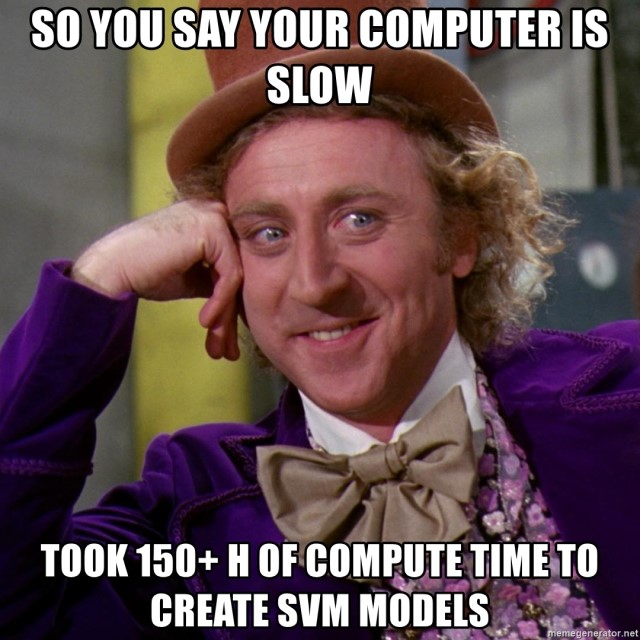


**!!! Warning !!! Run at your own  risk**

In [29]:
svd = decomposition.TruncatedSVD(n_components=120) # 120-200 is a good range
svd.fit(X_train_tfv)
X_train_svd = svd.transform(X_train_tfv)
X_test_svd = svd.transform(X_test_tfv)
#
scl = preprocessing.StandardScaler()
scl.fit(X_train_svd)
X_train_svd_scl = scl.transform(X_train_svd)
X_test_svd_scl = scl.transform(X_test_svd)

In [30]:
%%time

# it never ends :v

clf = OneVsRestClassifier(SVC(C=1.0, probability=True)) # since we need probabilities

model_predict(clf, X_train_svd_scl, y_train, X_test_svd_scl, y_test)

CPU times: user 0 ns, sys: 2 µs, total: 2 µs
Wall time: 5.01 µs


# XGBoost

In [31]:
%%time
clf = OneVsRestClassifier(xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8,
#                         tree_method='gpu_hist', gpu_id=0, 
#                         use_label_encoder=False,
                        subsample=0.8, nthread=10, learning_rate=0.01))
model_predict(clf, X_train_tfv, y_train, X_test_tfv, y_test)

logloss: 13.979
0.276
0.4330756155069364
CPU times: user 42min 21s, sys: 1.76 s, total: 42min 23s
Wall time: 4min 11s


In [32]:
%%time
model_predict(clf, X_train_ctv, y_train, X_test_ctv, y_test)

logloss: 13.931
0.279
0.43682072675376005
CPU times: user 1h 58min 18s, sys: 656 ms, total: 1h 58min 19s
Wall time: 15min 22s


## Grid Search

In [33]:
model_scorer = metrics.make_scorer(metrics.log_loss, greater_is_better=False, needs_proba=True)

# model_scorer = metrics.make_scorer(metrics.roc_auc_score, greater_is_better=True, needs_proba=True)


svd = TruncatedSVD()
  
scl = preprocessing.StandardScaler()

# `ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty` fix
# https://stackoverflow.com/a/60868685/11105356

lr_model = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
# Solver lbfgs supports only 'l2' or 'none' penalties
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])


param_grid = {'svd__n_components' : [120, 200],
              'lr__estimator__C': [0.1, 1.0, 10],
              'lr__estimator__penalty': ['l1', 'l2']}


model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=model_scorer,
                                 verbose=10, n_jobs=-1, refit=True, cv=2)

In [ ]:
%%time

model.fit(X_train_tfv, y_train)  # we can use the full data here but im only using xtrain
print(f"Best score: {model.best_score_:0.3f}")

print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()

for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

## Word Vectors
### Universal Sentence Encoder from TF-HUB

---
GPU was capped at **10%-20%**, took approximately 50 minutes for each run (train and test embedding)

In [35]:
X_train = []
for r in tqdm(train_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_train.append(review_emb)

X_train = np.array(X_train)

  0%|          | 0/26596 [00:00<?, ?it/s]


InvalidArgumentError: Graph execution error:

input must be a vector, got shape: []
	 [[{{node text_preprocessor/tokenize/StringSplit/StringSplit}}]] [Op:__inference_restored_function_body_4562]

In [ ]:
X_test = []
for r in tqdm(test_reviews):
    emb = use(r)
    review_emb = tf.reshape(emb, [-1]).numpy()
    X_test.append(review_emb)

X_test = np.array(X_test)

In [ ]:
print(X_train.shape, X_test.shape)

In [ ]:
print(y_train.shape, y_test.shape)

## Deep Learning Modeling

## Utility Function

In [ ]:
# plot accuracy and loss
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy= history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
# plot model architecture
def plot_model(model):
    model.summary()
    return tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    )

# Baseline NN Model

In [ ]:
def build_model_1():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.001))
    return model

In [ ]:
model_1 = build_model_1()
plot_model(model_1)

In [ ]:
history = model_1.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, # since the data dimension is big
    verbose=1, 
    shuffle=True
)

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [ ]:
# mode levaluation
model_1.evaluate(X_test, y_test)

## Prediction

In [ ]:
# predict_classes() was removed in tf 2.6+, predict_proba(): use predict()
# https://keras.rstudio.com/reference/predict_proba.html#details

# check keras source code
# https://github.com/keras-team/keras/blob/f0eb8d538c82798944346b4b2df917a06bf5e9d4/keras/engine/sequential.py#L254

y_pred_probas = model_1.predict(X_test) 
y_pred_classes = (y_pred_probas > 0.5).astype('int32')

### Test Samples

In [ ]:
print(test_reviews.iloc[0])
print("Bad" if y_pred_classes[0] == 0 else "Good", y_pred_probas[0])

In [ ]:
print(test_reviews.iloc[5])
print("Bad" if y_test[5] == 0 else "Good")

In [ ]:
print(y_pred_probas[5])
"Bad" if  y_pred_classes[5] == 0 else "Good"

# LSTM Model

In [ ]:
y_train.shape

## Reshape Dataset

**For an LSTM layer, you need the shape like  `(NumberOfExamples, TimeSteps, FeaturesPerStep)`**

In [ ]:
X_train_reshaped = X_train[:, newaxis,:]
X_test_reshaped = X_test[:, newaxis,:]

In [ ]:
X_train_reshaped.shape

In [ ]:
# input_shape
1,X_train_reshaped.shape[2]

## LSTM_1

In [ ]:
def build_model_lstm():
    model = Sequential()
    model.add(LSTM(256, activation='sigmoid', return_sequences=True,
                 input_shape=(1,X_train_reshaped.shape[2])
                 ))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.0005))
    return model

In [ ]:
model_lstm_1 = build_model_lstm()
plot_model(model_lstm_1)

In [ ]:
%%time

history_lstm_1 = model_lstm_1.fit(
    X_train_reshaped, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True # text data, safe to shuffle
)

In [ ]:
plot_history(history_lstm_1)

In [ ]:
model_lstm_1.evaluate(X_test_reshaped, y_test)

## LSTM_2

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

def build_model_lstm_2():
    model = Sequential()
    model.add(LSTM(256, activation='relu', return_sequences=True,
                 input_shape=(1,X_train_reshaped.shape[2])
                 ))
    model.add(LSTM(128, dropout=0.2, activation='relu', return_sequences=True))
    model.add(LSTM(64, dropout=0.2, activation='relu',  return_sequences=True))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.0005))
    return model

In [ ]:
model_lstm_2 = build_model_lstm_2()
plot_model(model_lstm_2)

In [ ]:
%%time
history = model_lstm_2.fit(
    X_train_reshaped, y_train, 
    epochs=10, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

In [ ]:
plot_history(history)

In [ ]:
model_lstm_2.evaluate(X_test_reshaped, y_test)

# Bi-LSTM

There is no final, definite, rule of thumb on how many nodes (or hidden neurons) or how many layers one should choose, and very often a trial and error approach will give you the best results for your individual problem. The most common framework for this is most likely the k-fold cross-validation. However, even for a testing procedure, we need to choose some (k) numbers of nodes.

The following formula may give you a starting point, [Check out the post here](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw/136542#136542)

---
<img src="https://user-images.githubusercontent.com/40615350/156080888-6b0a7f65-be66-46b8-83b4-bdf0422fdf4d.png">

In [ ]:
X_train.shape[0]

In [ ]:
# alpha value 2 works pretty well for most cases

X_train.shape[0] / (2* (X_train.shape[1]+1))

# according to the result (~127 ≈ 128) I will use 128 units per hidden layers

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [ ]:
def build_model_lstm_3():
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True),
                 input_shape=(1,X_train_reshaped.shape[2])
                 ))
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
#     model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
            metrics=['accuracy'],
            optimizer=Adam(learning_rate=0.0005))
    return model

In [ ]:
model_lstm_3 = build_model_lstm_3()
plot_model(model_lstm_3)

In [ ]:
%%time
history = model_lstm_3.fit(
    X_train_reshaped, y_train, 
    epochs=10, 
    batch_size=64, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True,
    callbacks=[reduce_lr]
)

In [ ]:
plot_history(history)

The model looks not bad,
It's less overfitting

In [ ]:
model_lstm_3.evaluate(X_test_reshaped, y_test)

# Serve Model

## Save Model

In [ ]:
model_lstm_2.save("lstm_sentiment_model.h5")

## Load Model

In [ ]:
imported_model = tf.keras.models.load_model('./lstm_sentiment_model.h5')
imported_model.summary()

## Prediction

### Positive Sentiment

In [ ]:
text = 'This room is great'
emb_test = use(text)
emb_test.shape

In [ ]:
emb_test_reshaped = emb_test[:, newaxis, :]
emb_test_reshaped.shape

In [ ]:
np.squeeze(imported_model.predict(emb_test_reshaped))[()]

In [ ]:
(imported_model.predict(emb_test_reshaped)[0][0][0] > 0.5).astype('int32')

In [ ]:
sentiment_val = (imported_model.predict(emb_test_reshaped) > 0.5).astype('int32')

"Good" if sentiment_val == 1 else "Bad"

### Negative Sentiment

In [ ]:
text = 'This room is small'
emb_test = use(text)

emb_test_reshaped = emb_test[:, newaxis, :]
emb_test_reshaped.shape

np.squeeze(imported_model.predict(emb_test_reshaped))[()]

In [ ]:
sentimen_val = (imported_model.predict(emb_test_reshaped) > 0.5).astype('int32')

"Good" if sentimen_val == 1 else "Bad"

## Prediction Pipeline

In [ ]:
def predict_sentiment(txt):
    emb_txt = use(txt)
    emb_test_reshaped = emb_txt[:, newaxis, :]
    sentiment_val = (imported_model.predict(emb_test_reshaped) > 0.5).astype('int32')
    print("Score:", imported_model.predict(emb_test_reshaped).flatten()[0])
    return "Positive" if sentiment_val == 1 else "Negative"

In [ ]:
sample_text = "I love the room service"
print(f"The sentiment of this sentence is : {predict_sentiment(sample_text)}")

In [ ]:
sample_text = "I like the room service but the bathroom is small"
print(f"The sentiment of this sentence is : {predict_sentiment(sample_text)}")

In [ ]:
sample_text = "The windows is so big. it has good air circulation"
print(f"The sentiment of this sentence is : {predict_sentiment(sample_text)}")

In [ ]:
sample_text = "The windows is so small. it has bad air circulation"
print(f"The sentiment of this sentence is : {predict_sentiment(sample_text)}")

## API 

#### I developed an API utilizing FastAPI for this project, check it out on GitHub -
#### - [SA With Universal Sentence Encoder API](https://github.com/ahmedshahriar/Sentiment-Analysis/tree/main/SA-with-Universal-Sentence-Encoder)

#### Also, check this notebook where I demonstrated deployment of the text classification REST API -
#### - [FastAPI On Kaggle Notebook (Ngrok+Postman)](https://www.kaggle.com/code/ahmedshahriarsakib/fastapi-on-kaggle-notebook-ngrok-postman)

# Conclusion
- LSTM performs comparatively better than baseline fully connected dense model
- In order to achieve a balanced distribution between positive and negative reviews, the positive reviews are down sampled, hence discarding lots of valuable information
- More resampling technique like - SMOTE, NLP augmentation like [nlpaug](https://github.com/makcedward/nlpaug) can be used to improve the performance

## In this notebook I performed text classification applying various feature engineering and modeling techniques

## Please give an upvote and share the notebook if you find it useful!

## Thank you!

---

### Here is a good LSTM meme

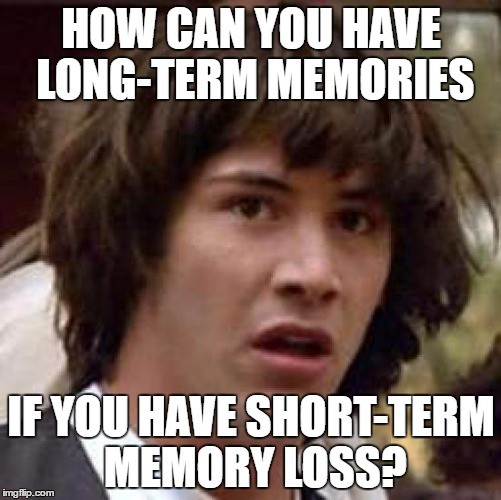